In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

%matplotlib inline

# Movie Recommender

## 1. Load data

In [2]:
ratings = pd.read_csv("data/movie_recommender/ratings.csv")
movies = pd.read_csv("data/movie_recommender/movies.csv")

In [3]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings = ratings.drop(columns="timestamp")
movies = movies.drop(columns="genres")

In [6]:
movies.shape

(9742, 2)

In [7]:
ratings.shape

(100836, 3)

In [8]:
ratings["userId"].nunique()

610

## 2. Create feature set

based on user ratings for movies

Dataset design:

| movieId | user1 | user2 | ... | userN |
|---------|-------|-------|-----|-------|
| 1 | NA | 1 | ... | 5 |
| 2 | 3 | NA | ... | 2 |


### First, however, we need to filter movies with almost no ratings. Those may not yield meaningful recommendations.

1. Count ratings for each movieId
2. join ratings on count from previous step
3. fitler

In [9]:
no_of_ratings = (ratings
                 .groupby("movieId", as_index=False)
                 .agg({"userId": "count"})
                 .rename(columns={"userId": "no_of_ratings"}))

In [10]:
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [11]:
df = ratings.merge(movies, how="left", on="movieId")

In [12]:
df = df.merge(no_of_ratings, how="left", on="movieId")

In [13]:
df.head()

,userId,movieId,rating,title,no_of_ratings
0,1,1,4.0,Toy Story (1995),215
1,1,3,4.0,Grumpier Old Men (1995),52
2,1,6,4.0,Heat (1995),102
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),203
4,1,50,5.0,"Usual Suspects, The (1995)",204


### Plot distribution of no_of_ratings

In [14]:
no_of_ratings

,movieId,no_of_ratings
0,1,215
1,2,110
2,3,52
3,4,7
4,5,49
...,...,...
9719,193581,1
9720,193583,1
9721,193585,1
9722,193587,1


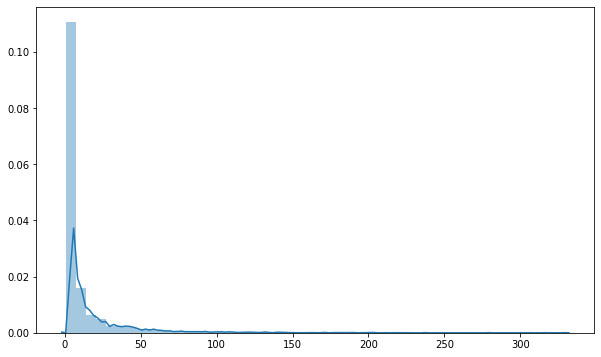

In [15]:
plt.figure(figsize=(10,6))
sns.distplot(no_of_ratings.set_index("movieId"));

In [16]:
no_of_ratings.describe()

,movieId,no_of_ratings
count,9724.000000,9724.000000
mean,42245.024373,10.369807
std,52191.137320,22.401005
min,1.000000,1.000000
25%,3245.500000,1.000000
50%,7300.000000,3.000000
75%,76739.250000,9.000000
max,193609.000000,329.000000


Set lower threshold for no_of_ratings to 5

In [17]:
min_threshold = 5
final_movies = df[df["no_of_ratings"] >= 5].copy()

### Create feature set

| movieId | user1 | user2 | ... | userN |
|---------|-------|-------|-----|-------|
| 1 | NA | 1 | ... | 5 |
| 2 | 3 | NA | ... | 2 |

In [18]:
movie_features = final_movies.pivot_table(index="movieId",
                                          columns="userId",
                                          values="rating").fillna(0)

In [19]:
movie_features.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [138]:
with open("movie_recommender/movie_features.pkl", "wb") as mf:
    pickle.dump(movie_features, mf, protocol=pickle.HIGHEST_PROTOCOL)

# 3. Modelling

In [20]:
from scipy.sparse import csr_matrix

In [21]:
mat_movie_features = csr_matrix(movie_features)

## 3.1. Train KNN (K-Nearest-Neighbors)

In [22]:
from sklearn.neighbors import NearestNeighbors

In [23]:
model_knn = NearestNeighbors(metric="cosine",
                             algorithm="brute",
                             n_jobs=-1)
model_knn.fit(mat_movie_features)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1)

In [139]:
with open("movie_recommender/model_knn.pkl", "wb") as mk:
    pickle.dump(model_knn, mk, protocol=pickle.HIGHEST_PROTOCOL)

In [24]:
movie_features.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
movie_features.loc[1].values.reshape(1, -1)

array([[4. , 0. , 0. , 0. , 4. , 0. , 4.5, 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 2.5, 0. , 4.5, 3.5, 4. , 0. , 3.5, 0. , 0. , 0. , 0. , 0. ,
        3. , 0. , 0. , 0. , 5. , 3. , 3. , 0. , 0. , 0. , 0. , 0. , 0. ,
        5. , 0. , 0. , 5. , 3. , 4. , 5. , 0. , 0. , 0. , 3. , 0. , 0. ,
        0. , 3. , 0. , 0. , 5. , 0. , 0. , 0. , 0. , 0. , 5. , 4. , 0. ,
        4. , 0. , 2.5, 0. , 0. , 5. , 0. , 4.5, 0. , 0. , 0.5, 0. , 4. ,
        0. , 0. , 0. , 2.5, 0. , 0. , 0. , 4. , 0. , 0. , 3. , 3. , 4. ,
        0. , 3. , 0. , 0. , 5. , 0. , 4.5, 0. , 0. , 0. , 0. , 4. , 0. ,
        0. , 0. , 4. , 0. , 0. , 0. , 0. , 3. , 0. , 0. , 0. , 0. , 0. ,
        0. , 3.5, 0. , 4. , 0. , 0. , 4. , 0. , 0. , 0. , 0. , 0. , 3. ,
        0. , 2. , 0. , 3. , 4. , 0. , 4. , 0. , 0. , 3. , 4. , 0. , 0. ,
        3.5, 5. , 0. , 0. , 0. , 0. , 0. , 5. , 0. , 2. , 0. , 3. , 4. ,
        0. , 0. , 4.5, 4. , 4. , 0. , 0. , 0. , 0. , 5. , 3.5, 0. , 4.5,
        0. , 5. , 0. , 0. , 0. , 0. , 0. , 5. , 4. 

In [26]:
model_knn.kneighbors(movie_features.loc[1].values.reshape(1, -1), n_neighbors=6)

(array([[0.        , 0.42739874, 0.4343632 , 0.43573831, 0.44261183,
         0.45290409]]),
 array([[   0, 1545,  306,  429,  169,  231]]))

In [27]:
movie_features.iloc[306]

userId
1      4.0
2      0.0
3      0.0
4      0.0
5      0.0
      ... 
606    2.5
607    4.0
608    3.0
609    3.0
610    5.0
Name: 480, Length: 610, dtype: float64

In [28]:
movies[movies["movieId"] == 480]

,movieId,title
418,480,Jurassic Park (1993)


Our kNN model returns a tuple of two 2d-arrays, containing distances and indeces of the nearest neighbors of the vector passed. In order for us to match the results with movieIds or Titles, we need to translate the output.

# 4. Making our recommender more user-friendly

### 4.1. Translate model output (recommendations) to titles

In [29]:
distances, indices = model_knn.kneighbors(movie_features.loc[1].values.reshape(1, -1), n_neighbors=6)

In [31]:
indices

array([[   0, 1545,  306,  429,  169,  231]])

In [32]:
movies

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)
...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017)
9738,193583,No Game No Life: Zero (2017)
9739,193585,Flint (2017)
9740,193587,Bungo Stray Dogs: Dead Apple (2018)


In [42]:
movie_list = final_movies[["movieId", "title"]].drop_duplicates().sort_values("movieId").reset_index(drop=True)

In [44]:
movie_list.iloc[1545]

movieId                  3114
title      Toy Story 2 (1999)
Name: 1545, dtype: object

In [140]:
with open("movie_recommender/movie_list.pkl", "wb") as ml:
    pickle.dump(movie_list, ml, protocol=pickle.HIGHEST_PROTOCOL)

In [48]:
indices.flatten()

array([   0, 1545,  306,  429,  169,  231])

In [57]:
for i, j in enumerate(indices.flatten()):
    movie = movie_list.iloc[j]
    name = movie["title"]
    if i == 0:
        print(f"Recommendations for {name}:")
        print("-----------------------------------------\n")
    else:
        print(f"{i}: {name}")

Recommendations for Toy Story (1995):
-----------------------------------------

1: Toy Story 2 (1999)
2: Jurassic Park (1993)
3: Independence Day (a.k.a. ID4) (1996)
4: Star Wars: Episode IV - A New Hope (1977)
5: Forrest Gump (1994)


In [63]:
distances

array([[0.        , 0.42739874, 0.4343632 , 0.43573831, 0.44261183,
        0.45290409]])

In [64]:
def print_recommendations(knn_output):
    distances, indices = knn_output
    
    for i, res in enumerate(zip(distances.flatten(), indices.flatten())):
        distance, index = res
        name = movie_list.iloc[index]["title"]
        if i == 0:
            print(f"Recommendations for {name}:")
            print("-----------------------------------------\n")
        else:
            print(f"{i}: {name}, with distance {round(distance,2)}")

In [58]:
a = (1,2,3)
b = ("a", "b", "c")

In [60]:
list(zip(a,b))

[(1, 'a'), (2, 'b'), (3, 'c')]

In [62]:
for i in enumerate(zip(a,b)):
    print(i)

(0, (1, 'a'))
(1, (2, 'b'))
(2, (3, 'c'))


In [65]:
print_recommendations(model_knn.kneighbors(movie_features.loc[1].values.reshape(1, -1), n_neighbors=6))

Recommendations for Toy Story (1995):
-----------------------------------------

1: Toy Story 2 (1999), with distance 0.43
2: Jurassic Park (1993), with distance 0.43
3: Independence Day (a.k.a. ID4) (1996), with distance 0.44
4: Star Wars: Episode IV - A New Hope (1977), with distance 0.44
5: Forrest Gump (1994), with distance 0.45


## 4.2. Translate `movieId` to movie-vector

In [78]:
def movieid_to_vec(movie_id):
    return movie_features.loc[movie_id].values.reshape(1, -1)

In [79]:
movieid_to_vec(999)

array([[0. , 0. , 0. , 0. , 0. , 2. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 2. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 4. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. 

In [80]:
print_recommendations(model_knn.kneighbors(movieid_to_vec(999), n_neighbors=6))

Recommendations for 2 Days in the Valley (1996):
-----------------------------------------

1: Sirens (1994), with distance 0.44
2: Krull (1983), with distance 0.47
3: Bound (1996), with distance 0.51
4: Beastmaster, The (1982), with distance 0.52
5: Princess Caraboo (1994), with distance 0.53


## 4.3. Allow title queries as input

Extend on the previous example by allowing input as title instead of movieId. We're building a super simple search engine.
We want to allow title queries to match titles in our database to retrieve movieIds.

In [81]:
movie_list

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)
...,...,...
3645,180031,The Shape of Water (2017)
3646,180985,The Greatest Showman (2017)
3647,183897,Isle of Dogs (2018)
3648,187593,Deadpool 2 (2018)


Create a dictionary, that maps titles (keys) to movieIds (values)

In [84]:
movie_list.set_index("movieId").to_dict()["title"]

{1: 'Toy Story (1995)',
 2: 'Jumanji (1995)',
 3: 'Grumpier Old Men (1995)',
 4: 'Waiting to Exhale (1995)',
 5: 'Father of the Bride Part II (1995)',
 6: 'Heat (1995)',
 7: 'Sabrina (1995)',
 8: 'Tom and Huck (1995)',
 9: 'Sudden Death (1995)',
 10: 'GoldenEye (1995)',
 11: 'American President, The (1995)',
 12: 'Dracula: Dead and Loving It (1995)',
 13: 'Balto (1995)',
 14: 'Nixon (1995)',
 15: 'Cutthroat Island (1995)',
 16: 'Casino (1995)',
 17: 'Sense and Sensibility (1995)',
 18: 'Four Rooms (1995)',
 19: 'Ace Ventura: When Nature Calls (1995)',
 20: 'Money Train (1995)',
 21: 'Get Shorty (1995)',
 22: 'Copycat (1995)',
 23: 'Assassins (1995)',
 24: 'Powder (1995)',
 25: 'Leaving Las Vegas (1995)',
 26: 'Othello (1995)',
 27: 'Now and Then (1995)',
 28: 'Persuasion (1995)',
 29: 'City of Lost Children, The (Cité des enfants perdus, La) (1995)',
 31: 'Dangerous Minds (1995)',
 32: 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)',
 34: 'Babe (1995)',
 36: 'Dead Man Walking (1995)',
 39:

In [86]:
# using dict comprehension
movie_map = {title: movie_id for movie_id, title in movie_list.set_index("movieId").to_dict()["title"].items()}

In [88]:
movie_map["GoldenEye (1995)"]

10

In [141]:
with open("movie_recommender/movie_map.pkl", "wb") as mm:
    pickle.dump(movie_map, mm, protocol=pickle.HIGHEST_PROTOCOL)

### Qucik intro to fuzzy strings matching so we can introduce tolerance to search queries

In [89]:
from fuzzywuzzy import fuzz

In [90]:
fuzz.ratio("Hello", "Hello")

100

In [91]:
fuzz.ratio("Hello", "Hellu")

80

In [95]:
fuzz.ratio("goledeney", "GoldenEye (1995)".lower())

64

Extract movie title:

In [96]:
import re

In [97]:
ex_title = "City of Lost Children, The (Cité des enfants perdus, La) (1995)"

In [99]:
title_pattern = r"(.*)\s\(\d{4}\)$"
extr_title, = re.findall(title_pattern, ex_title)

In [100]:
extr_title

'City of Lost Children, The (Cité des enfants perdus, La)'

Taking an input string and compute the fuzzywuzzy ratio against all titles in our database

In [102]:
input_title = "lord of the rings"

In [116]:
matches = []
for title, movie_id in movie_map.items():
    
    # remove the year
    title_pattern = r"(.*)\s\(\d{4}\)$"
    extr_title, = re.findall(title_pattern, title)
    
    # compute the ratio and remove case-sensitivity
    ratio = fuzz.ratio(extr_title.lower(), input_title)
    
    # add all matches to list, if ratio > 60
    if ratio > 60:
        matches.append((extr_title, movie_id, ratio))

In [117]:
matches

[('Lord of Illusions', 177, 65),
 ('Father of the Bride', 934, 61),
 ('George of the Jungle', 1588, 65),
 ('Wild Things', 1805, 64),
 ('Lord of the Rings, The', 2116, 87),
 ('Children of the Corn', 2122, 65),
 ('Do the Right Thing', 3424, 63),
 ('Lord of the Flies', 3461, 82),
 ('Lord of the Flies', 4951, 82),
 ('Clash of the Titans', 5540, 67),
 ('Lord of the Rings: The Two Towers, The', 5952, 62),
 ('Tears of the Sun', 6213, 61),
 ('Father of the Bride', 6944, 61),
 ('Lords of Dogtown', 33672, 61),
 ('War of the Worlds', 34048, 65),
 ('Lord of War', 36529, 64),
 ('Land of the Lost', 69278, 67),
 ('Clash of the Titans', 76175, 67),
 ('Love and Other Drugs', 82167, 65),
 ('Rise of the Guardians', 98243, 68),
 ('Band of Brothers', 170705, 61)]

In [118]:
sorted(matches, key=lambda x: x[2], reverse=True)

[('Lord of the Rings, The', 2116, 87),
 ('Lord of the Flies', 3461, 82),
 ('Lord of the Flies', 4951, 82),
 ('Rise of the Guardians', 98243, 68),
 ('Clash of the Titans', 5540, 67),
 ('Land of the Lost', 69278, 67),
 ('Clash of the Titans', 76175, 67),
 ('Lord of Illusions', 177, 65),
 ('George of the Jungle', 1588, 65),
 ('Children of the Corn', 2122, 65),
 ('War of the Worlds', 34048, 65),
 ('Love and Other Drugs', 82167, 65),
 ('Wild Things', 1805, 64),
 ('Lord of War', 36529, 64),
 ('Do the Right Thing', 3424, 63),
 ('Lord of the Rings: The Two Towers, The', 5952, 62),
 ('Father of the Bride', 934, 61),
 ('Tears of the Sun', 6213, 61),
 ('Father of the Bride', 6944, 61),
 ('Lords of Dogtown', 33672, 61),
 ('Band of Brothers', 170705, 61)]

In [120]:
sorted(matches, key=lambda x: x[2], reverse=True)[0][1]

2116

In [121]:
print_recommendations(model_knn.kneighbors(movieid_to_vec(2116), n_neighbors=6))

Recommendations for Lord of the Rings, The (1978):
-----------------------------------------

1: Excalibur (1981), with distance 0.46
2: Transformers: The Movie (1986), with distance 0.47
3: Six-String Samurai (1998), with distance 0.51
4: Young Sherlock Holmes (1985), with distance 0.53
5: Ladyhawke (1985), with distance 0.54


In [126]:
def find_movie_id(query):
    matches = []
    for title, movie_id in movie_map.items():

        # remove the year
        title_pattern = r"(.*)\s\(\d{4}\)$"
        extr_title, = re.findall(title_pattern, title)

        # compute the ratio and remove case-sensitivity
        ratio = fuzz.ratio(extr_title.lower(), query)

        # add all matches to list, if ratio > 60
        if ratio > 60:
            matches.append((extr_title, movie_id, ratio))
            
    if not matches:
        print("Sorry, could not find your movie :(")
        return
    
    return sorted(matches, key=lambda x: x[2], reverse=True)[0][1]

In [128]:
find_movie_id("gone in 60 seconds")

3717

In [130]:
print_recommendations(model_knn.kneighbors(movieid_to_vec(find_movie_id("gone in 60 seconds")), n_neighbors=6))

Recommendations for Gone in 60 Seconds (2000):
-----------------------------------------

1: Mission: Impossible II (2000), with distance 0.44
2: Fast and the Furious, The (2001), with distance 0.45
3: Miss Congeniality (2000), with distance 0.5
4: X-Men (2000), with distance 0.5
5: Mr. & Mrs. Smith (2005), with distance 0.52


# 5. Create one recommender function that wraps all steps

In [131]:
def recommend_movies(query, n=5):
    movie_id = find_movie_id(query)
    if not movie_id:
        return
    
    movie_vec = movieid_to_vec(movie_id)
    
    n_recs = n + 1
    recs = model_knn.kneighbors(movie_vec, n_neighbors=n_recs)
    
    print_recommendations(recs)

In [132]:
recommend_movies("forrest gump")

Recommendations for Forrest Gump (1994):
-----------------------------------------

1: Shawshank Redemption, The (1994), with distance 0.29
2: Jurassic Park (1993), with distance 0.31
3: Pulp Fiction (1994), with distance 0.31
4: Braveheart (1995), with distance 0.36
5: Silence of the Lambs, The (1991), with distance 0.36


In [133]:
recommend_movies("interstellar")

Recommendations for Interstellar (2014):
-----------------------------------------

1: Inception (2010), with distance 0.39
2: Django Unchained (2012), with distance 0.41
3: Dark Knight Rises, The (2012), with distance 0.42
4: Edge of Tomorrow (2014), with distance 0.43
5: The Imitation Game (2014), with distance 0.43


In [134]:
recommend_movies("inception")

Recommendations for Inception (2010):
-----------------------------------------

1: Dark Knight, The (2008), with distance 0.27
2: Inglourious Basterds (2009), with distance 0.35
3: Shutter Island (2010), with distance 0.38
4: Dark Knight Rises, The (2012), with distance 0.38
5: Fight Club (1999), with distance 0.38
